In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import math

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
class DeepONet(nn.Module):
    def __init__(self):
        super(DeepONet,self).__init__()
        self.Branch_L1 = nn.Linear(100,20)
        self.Branch_L2 = nn.Linear(20,20)
        self.Branch_L3 = nn.Linear(20,20)
        self.Branch_L4 = nn.Linear(20,20)
        self.Branch_L5 = nn.Linear(20,100)

        self.Trunk_L1 = nn.Linear(2,20)
        self.Trunk_L2 = nn.Linear(20,20)
        self.Trunk_L3 = nn.Linear(20,20)
        self.Trunk_L4 = nn.Linear(20,20)
        self.Trunk_L5 = nn.Linear(20,100)

        self.Final = nn.Linear(200,1)

    def forward(self,y_0,x_loc_and_time):
        # Branch
        b = F.tanh(self.Branch_L1(y_0))
        b = F.tanh(self.Branch_L2(b))
        b = F.tanh(self.Branch_L3(b))
        b = F.tanh(self.Branch_L4(b))
        b = self.Branch_L5(b)

        tr = F.tanh(self.Trunk_L1(x_loc_and_time))
        tr = F.tanh(self.Trunk_L2(tr))
        tr = F.tanh(self.Trunk_L3(tr))
        tr = F.tanh(self.Trunk_L4(tr))
        tr = self.Trunk_L5(tr)

        trial = self.Final(torch.cat((b,tr),-1))

        #output = torch.matmul(b,tr.t()).sum(dim=0)
        #output = torch.sum(b * tr, dim=1)

        return trial # output

model = DeepONet().to(device)

In [32]:
database = pd.read_csv('Dataset_1.csv',index_col=0).dropna().to_numpy(dtype='float32')

In [33]:
database.shape

(141000, 103)

In [34]:
class Data(Dataset):
    def __init__(self,transform=None):
        self.initial_conditions = torch.from_numpy(database[:,0:100])
        self.x_location = torch.from_numpy(database[:,[100]])
        self.time_vale = torch.from_numpy(database[:,[101]])
        self.true_y_value = torch.from_numpy(database[:,[102]])
        self.n_samples = database.shape[0]

    def __getitem__(self, index):
        return self.initial_conditions[index] , self.x_location[index] , self.time_vale[index] , self.true_y_value[index]
    
    def __len__(self):
        return self.n_samples

In [35]:
dataset_data = Data()

In [36]:
train_size = int(0.7*dataset_data.__len__())
test_size = dataset_data.__len__() - train_size

Burger_train_data , Burger_test_data = torch.utils.data.random_split(Data(),[train_size,test_size])

train_loader = DataLoader(dataset=Burger_train_data,batch_size=2500,shuffle=True)

In [37]:
data_iter = iter(train_loader)
data = data_iter.__next__()
Init_val , x_loc, time, y_value = data

In [38]:
num_epoch = 100
total_samples = len(train_loader)
n_iterations = math.ceil(total_samples/300)
print(total_samples,n_iterations)
learning_rate = 0.01

criterion = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(), lr=0.001)

loss_rec = []

40 1


In [39]:
for epoch in range(num_epoch):
    for i , (input_init_conditions,input_x_loc,input_time,Actual_y) in enumerate(train_loader):
        input1 = input_init_conditions
        input1 = input1.to(device)

        input2 = torch.cat((input_x_loc,input_time),-1)
        input2 = input2.to(device)

        Actual_y = Actual_y.to(device)

        Outputs = model(input1,input2)
        loss = criterion(Outputs,Actual_y)


        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        loss_rec.append(loss.item())

        if (i+1) % 10 ==0:
            print(f'Epoch [{epoch+1}/{num_epoch}] , Step [{i+1}/{total_samples}] , Loss: {loss.item():.16f}')

Epoch [1/100] , Step [10/40] , Loss: 0.4176186919212341
Epoch [1/100] , Step [20/40] , Loss: 0.4155151844024658
Epoch [1/100] , Step [30/40] , Loss: 0.4283935427665710
Epoch [1/100] , Step [40/40] , Loss: 0.4266500771045685
Epoch [2/100] , Step [10/40] , Loss: 0.4299789071083069
Epoch [2/100] , Step [20/40] , Loss: 0.4128030240535736
Epoch [2/100] , Step [30/40] , Loss: 0.4068979322910309
Epoch [2/100] , Step [40/40] , Loss: 0.4043379724025726
Epoch [3/100] , Step [10/40] , Loss: 0.4210578203201294
Epoch [3/100] , Step [20/40] , Loss: 0.4284727573394775
Epoch [3/100] , Step [30/40] , Loss: 0.4136566519737244
Epoch [3/100] , Step [40/40] , Loss: 0.4203307628631592
Epoch [4/100] , Step [10/40] , Loss: 0.4133393466472626
Epoch [4/100] , Step [20/40] , Loss: 0.4104634821414948
Epoch [4/100] , Step [30/40] , Loss: 0.4212741553783417
Epoch [4/100] , Step [40/40] , Loss: 0.3944238424301147
Epoch [5/100] , Step [10/40] , Loss: 0.4128709435462952
Epoch [5/100] , Step [20/40] , Loss: 0.410269379

In [40]:
input2.size()

torch.Size([1200, 2])

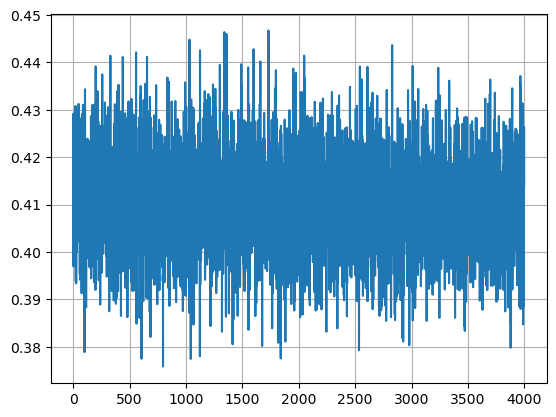

In [41]:
plt.plot(loss_rec)
plt.grid()

In [42]:
trial_input_1 = torch.tensor(np.random.rand(65,100),dtype=torch.float32).to(device)
trial_input_2 = torch.tensor(np.random.rand(65,2),dtype=torch.float32).to(device)
model(trial_input_1,trial_input_2).mean()
model(trial_input_1,trial_input_2).shape

torch.Size([65, 1])